# NEOs Classification

### Import Libraries & Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, balanced_accuracy_score

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler,NearMiss, TomekLinks

from imblearn.pipeline import Pipeline
#from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
import xgboost as xgb
from xgboost import XGBClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings('ignore')

from tqdm.notebook import tqdm
import datetime,time

In [2]:
df = pd.read_csv('neo.csv')
df.head()

,id,name,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,orbiting_body,sentry_object,absolute_magnitude,hazardous
0,2162635,162635 (2000 SS164),1.198271,2.679415,13569.249224,5.483974e+07,Earth,False,16.73,False
1,2277475,277475 (2005 WK4),0.265800,0.594347,73588.726663,6.143813e+07,Earth,False,20.00,True
2,2512244,512244 (2015 YE18),0.722030,1.614507,114258.692129,4.979872e+07,Earth,False,17.83,False
3,3596030,(2012 BV13),0.096506,0.215794,24764.303138,2.543497e+07,Earth,False,22.20,False
4,3667127,(2014 GE35),0.255009,0.570217,42737.733765,4.627557e+07,Earth,False,20.09,True


In [3]:
# describe data
print("Describe:\n")
print(df.describe())
print("--------------------------\n")
print("Shape:\n")
print(df.shape)
print("--------------------------\n")
print("Null Values:\n")
print((df.isnull().sum() / len(df)) * 100)
print("--------------------------\n")
print("Info:\n")
print(df.info(verbose=True))
print("--------------------------\n")
print("Unique values per column:\n")
for col in df.columns:
    print(col,'-->',df[col].nunique())

Describe:

                 id  est_diameter_min  est_diameter_max  relative_velocity  \
count  9.083600e+04      90836.000000      90836.000000       90836.000000   
mean   1.438288e+07          0.127432          0.284947       48066.918918   
std    2.087202e+07          0.298511          0.667491       25293.296961   
min    2.000433e+06          0.000609          0.001362         203.346433   
25%    3.448110e+06          0.019256          0.043057       28619.020645   
50%    3.748362e+06          0.048368          0.108153       44190.117890   
75%    3.884023e+06          0.143402          0.320656       62923.604633   
max    5.427591e+07         37.892650         84.730541      236990.128088   

       miss_distance  absolute_magnitude  
count   9.083600e+04        90836.000000  
mean    3.706655e+07           23.527103  
std     2.235204e+07            2.894086  
min     6.745533e+03            9.230000  
25%     1.721082e+07           21.340000  
50%     3.784658e+07        

In [4]:
# Let's check how many times each name is shown in the dataset
df.groupby('name').sum()['hazardous'].sort_values(ascending=False)

name
138175 (2000 EE104)    39
468910 (2014 KQ76)     35
418849 (2008 WM64)     34
85990 (1999 JV6)       33
164202 (2004 EW)       27
                       ..
(2016 DW1)              0
(2016 DV21)             0
(2016 DV1)              0
(2016 DU21)             0
(2017 YK8)              0
Name: hazardous, Length: 27423, dtype: int64

In [5]:
orbiting_body_values = ', '.join(str(value) for value in df['orbiting_body'].unique())
print('"orbiting_body" has', df['orbiting_body'].nunique(), 'unique value(s):', orbiting_body_values)

sentry_object_values = ', '.join(str(value) for value in df['sentry_object'].unique())
print('"sentry_object" has', df['sentry_object'].nunique(), 'unique value(s):', sentry_object_values)

"orbiting_body" has 1 unique value(s): Earth
"sentry_object" has 1 unique value(s): False


### Quick Observations:
- Some names/ids repeat themselves in the data (maybe different observations of the same object through time)
- Above assumption is backed up by the fact that relative velocity contains only distinct values
- Columns "orbiting_body" and "sentry_object" contain only 1 distinct value so they will be remove
- Columns  "est_diameter_min" and "est_diameter_max" have exactly the same amount of distinct values

### The columns name & id will be removed for the analysis
- Because of they many unique identifiers that don't add anything to the analysis will create noise for the model.
- Create a year column from name and check if it helps model performance later

### Using regex we extract the 4 digits that represent the year from each name.In case the name is inserted differently, it will be filled with value = -1 

In [6]:
# Extract the number out of the name, e.g. 162635 (2000 SS164) ---> 2000
import re

df['year'] = df['name'].str.extract(r'\((\d{4})').astype(float).fillna(-1).astype(int)

In [8]:
df.year.unique()

array([2000, 2005, 2015, 2012, 2014, 2021, 2001, 2016, 2020, 2022, 2017,
       2018, 2019, 2003, 2006, 2013, 1994, 1998, 1978, 1984, 1980, 2007,
       2009, 2011, 1991, 2004, 2002, 2010, 1990, 2008, 1999, 1993, 1997,
       1995, 1951, 1950, 1996, 1986, 1992, 1987, 1971, 1989, 1960, 1982,
       1953,   -1, 1976, 1973, 1936, 1988, 1977, 1937, 1985, 1948, 6743,
       1983, 1949, 1974, 1932, 1972, 4788, 6344, 1968, 1981, 1979, 1947,
       1959, 1975, 1929, 1963])

### After a closer look at values that were filled with -1, some of them need to be changed to their real values coming from NEOs site, e.g. A911 refers to 1911. Below the values that had to be changed.

In [9]:
df.loc[df.name=='719 Albert (A911 TB)','year']= 1911
df.loc[df.name=='433 Eros (A898 PA)','year']= 1898
df.loc[df.name=='(A/2019 Q2)','year']= 2019
df.loc[df.name=='1036 Ganymed (A924 UB)','year']= 1924
df.loc[df.name=='5011 Ptah (6743 P-L)','year']= 1960
df.loc[df.name=='145656 (4788 P-L)','year']= 1960
df.loc[df.name=='(6344 P-L)','year']= 1960

In [16]:
# Min Max in year column
print(f"The minimum year is {df['year'].min()} and the maximum year is {df['year'].max()}.")

The minimum year is 1898 and the maximum year is 2022.


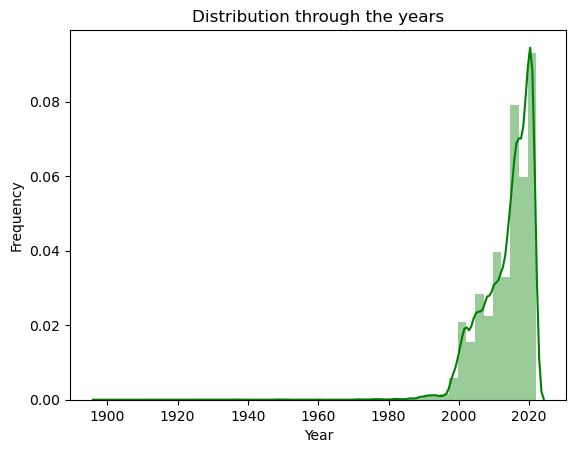

In [10]:
# Create a histogram 
sns.distplot(x=df.year,color='green')
# Set plot labels and title
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.title('Distribution through the years')

plt.show()

In [17]:
test = df.copy()

In [18]:
test.drop(['id','name','orbiting_body','sentry_object'],axis=1,inplace=True)
test.head()

,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,absolute_magnitude,hazardous,year
0,1.198271,2.679415,13569.249224,5.483974e+07,16.73,False,2000
1,0.265800,0.594347,73588.726663,6.143813e+07,20.00,True,2005
2,0.722030,1.614507,114258.692129,4.979872e+07,17.83,False,2015
3,0.096506,0.215794,24764.303138,2.543497e+07,22.20,False,2012
4,0.255009,0.570217,42737.733765,4.627557e+07,20.09,True,2014


### Check Distribution

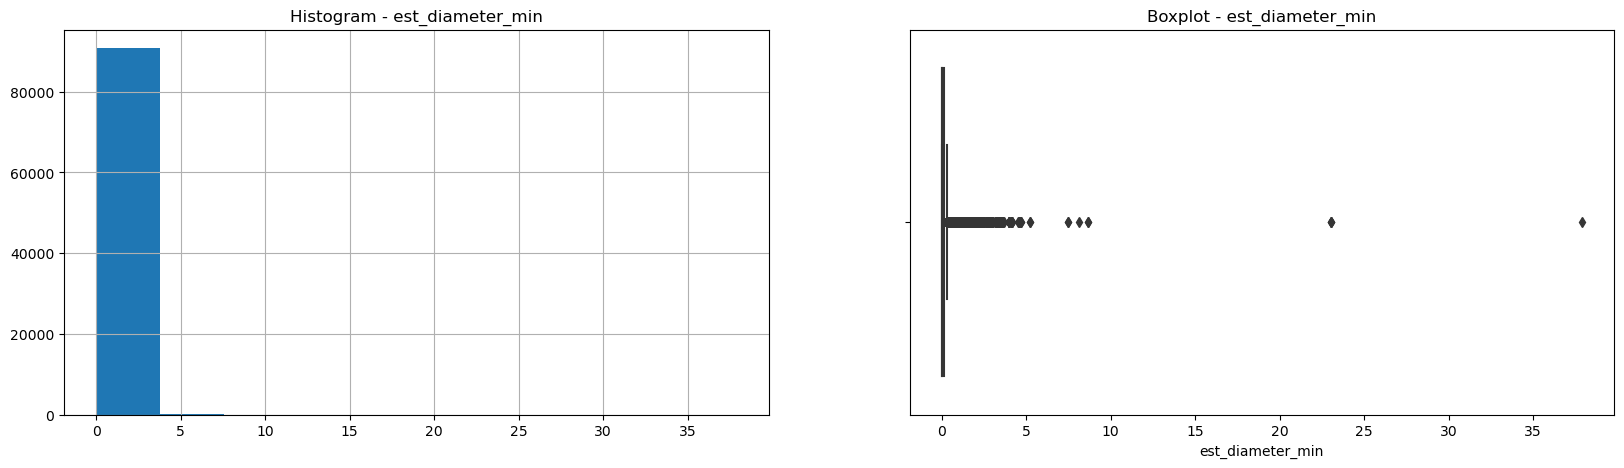

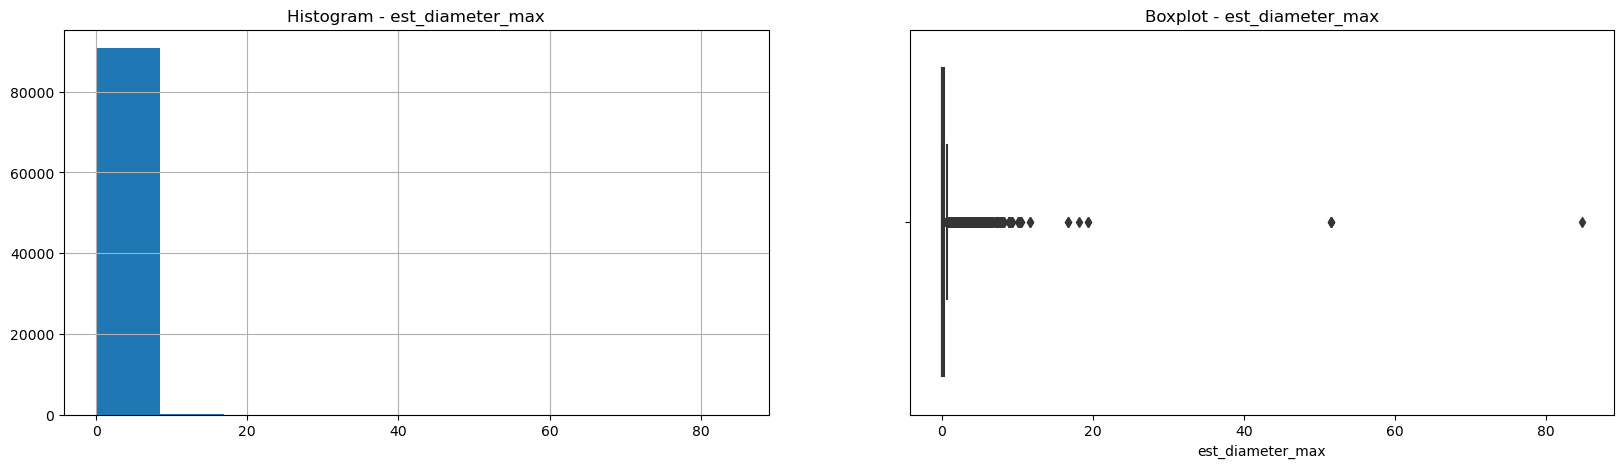

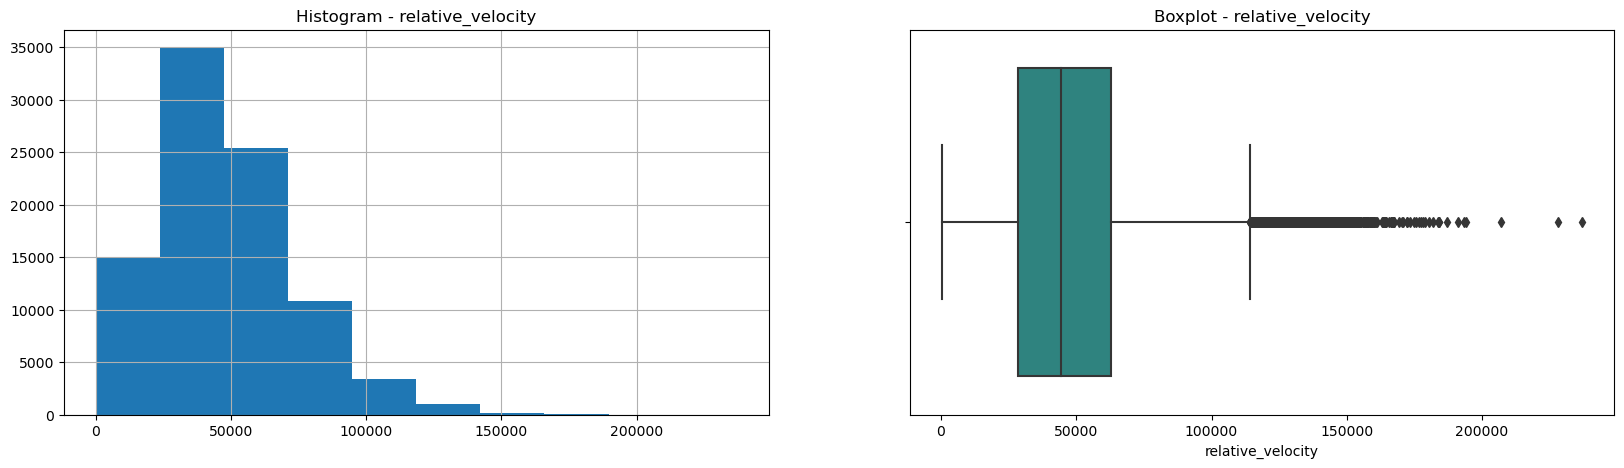

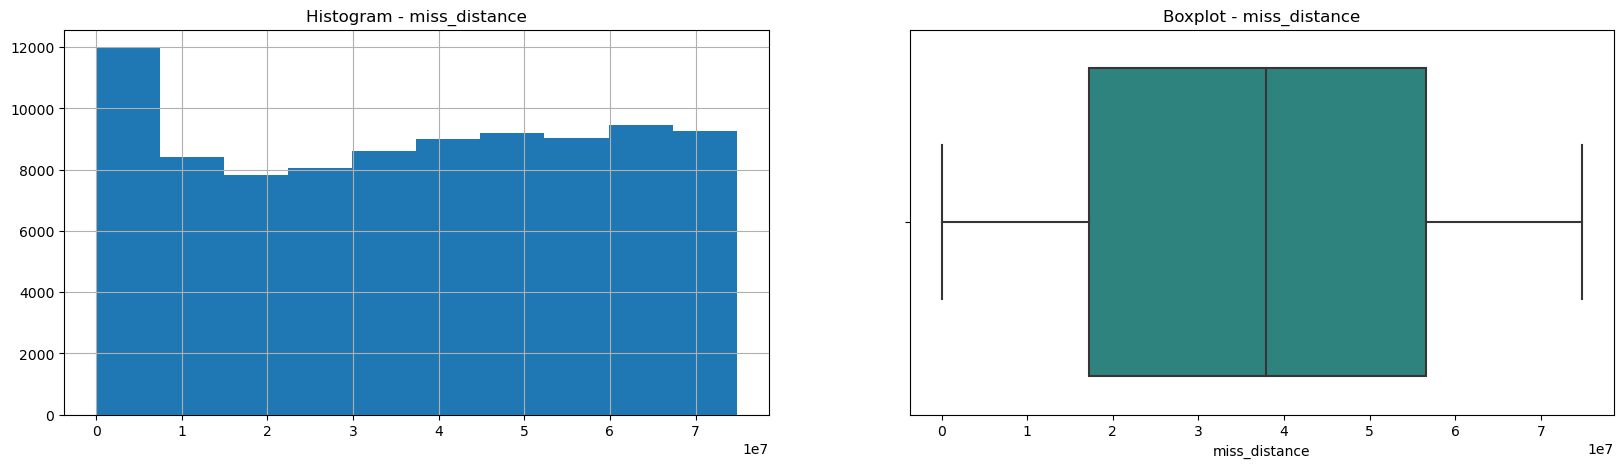

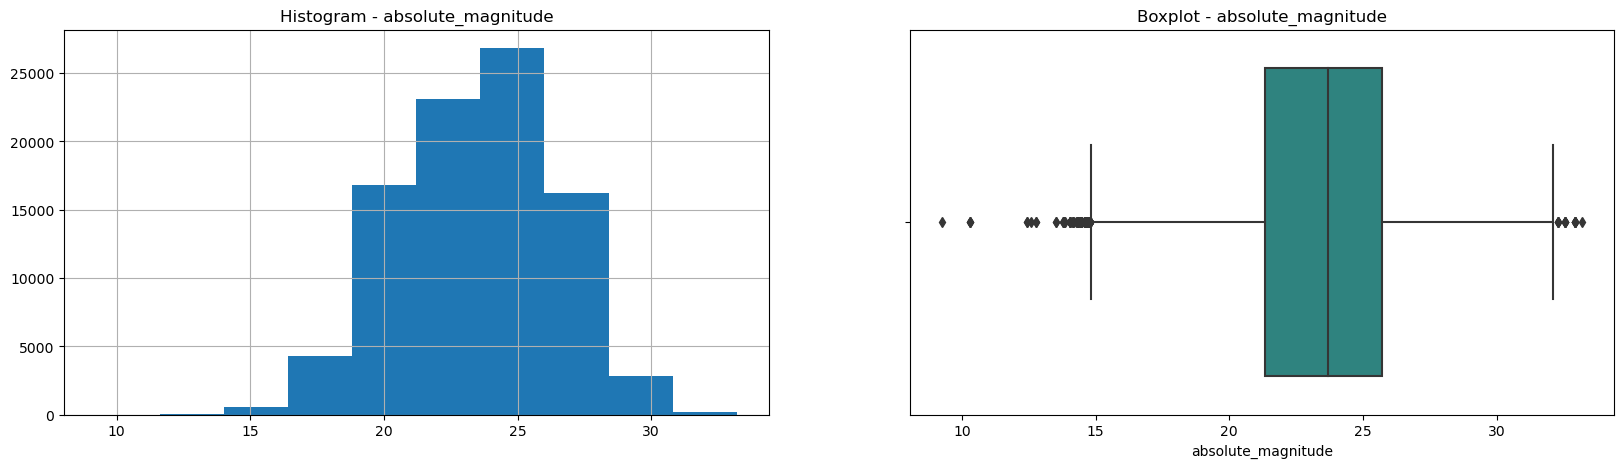

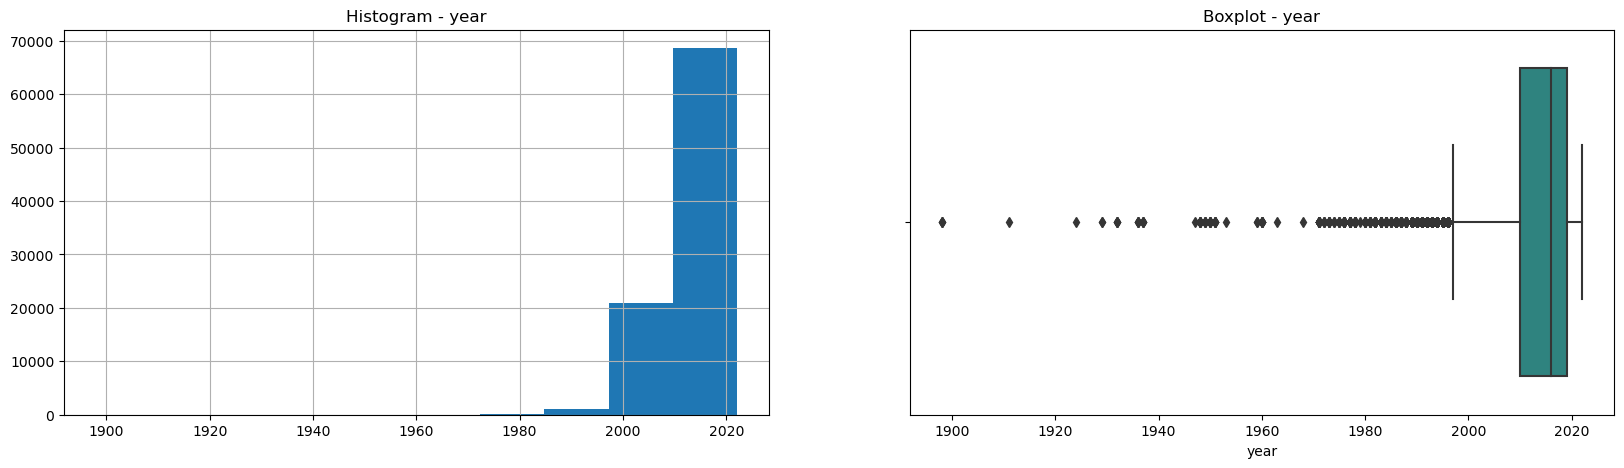

In [19]:
for col in test.select_dtypes(include=np.number).columns:
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    test[col].hist(ax=ax[0])
    sns.boxplot(x=test[col], ax=ax[1], palette='viridis')
    # Add titles to the plots
    ax[0].set_title(f'Histogram - {col}')
    ax[1].set_title(f'Boxplot - {col}')
    
    plt.show()

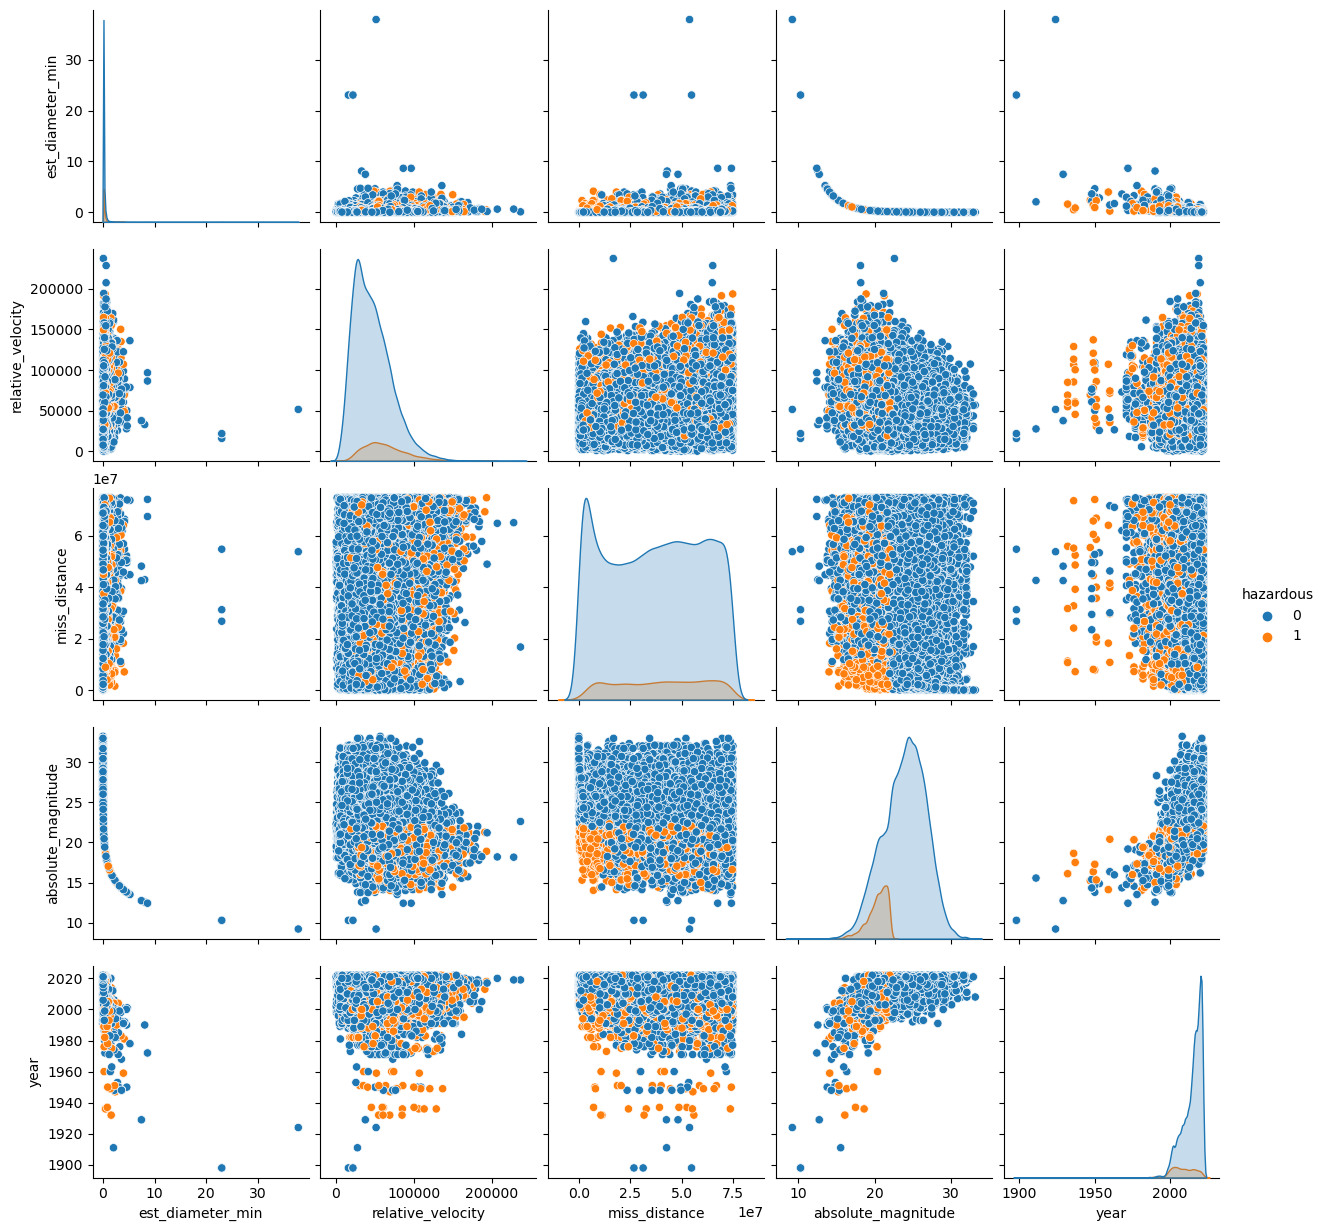

In [74]:
sns.pairplot(test, hue = "hazardous")

### Check the correlation between features
- Checking the correlation between the columns helps to avoid multicollinearity, which has a negative impact in model performance
- Dimensionality reduction by removing redundant variables lead to more efficient and accurate models

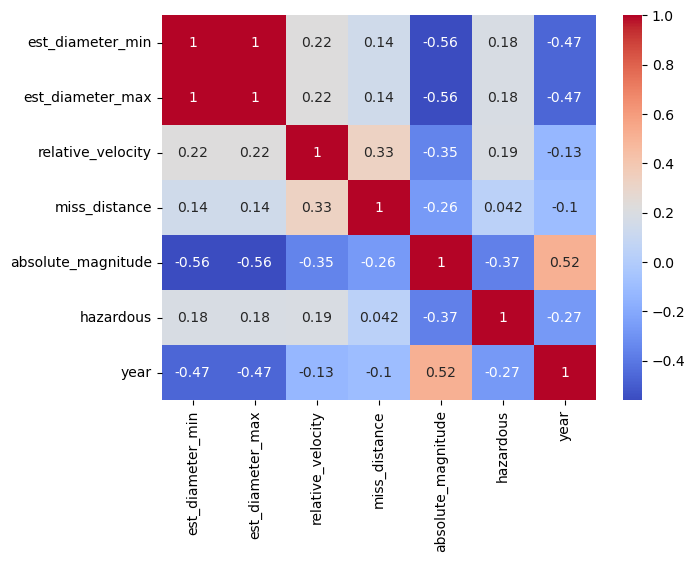

In [23]:
plt.figure(figsize=(7,5))
sns.heatmap(test.corr(),annot=True,cmap='coolwarm')
plt.show()

### The two columns “est_diameter_min” & “est_diameter_max” are perfectly correlated each other. 
As expected due to the same amount of unique values these two columns have a perfect correlation, we will keep only one for the model.

In [20]:
test.drop('est_diameter_max',axis=1,inplace=True)
test

,est_diameter_min,relative_velocity,miss_distance,absolute_magnitude,hazardous,year
0,1.198271,13569.249224,5.483974e+07,16.73,False,2000
1,0.265800,73588.726663,6.143813e+07,20.00,True,2005
2,0.722030,114258.692129,4.979872e+07,17.83,False,2015
3,0.096506,24764.303138,2.543497e+07,22.20,False,2012
4,0.255009,42737.733765,4.627557e+07,20.09,True,2014
...,...,...,...,...,...,...
90831,0.026580,52078.886692,1.230039e+07,25.00,False,2016
90832,0.016771,46114.605073,5.432121e+07,26.00,False,2019
90833,0.031956,7566.807732,2.840077e+07,24.60,False,2020
90834,0.007321,69199.154484,6.869206e+07,27.80,False,2021


### Checking for imbalanced dataset
- Check the target variable if the classes are imbalanced
- Class imbalance will create bias towards the majority class (Poor performance on the minority class)
- Poor performance on generalizing patterns of minority leading to overfitting on the majority class

In [21]:
# % of each class in the target column
(test['hazardous'].value_counts()/len(test))*100

False    90.268176
True      9.731824
Name: hazardous, dtype: float64

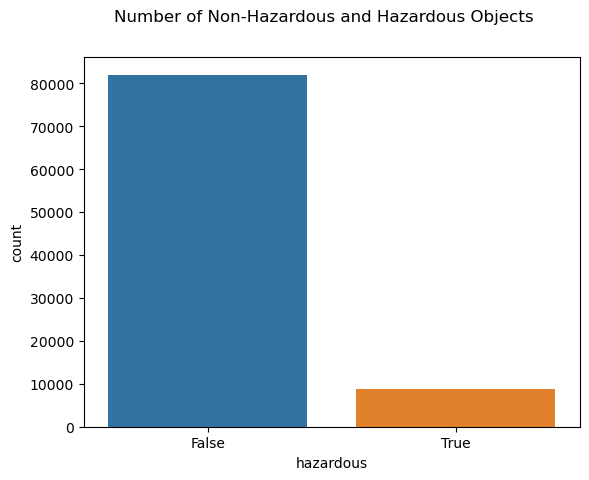

In [22]:
sns.countplot(x='hazardous',data=test)
plt.suptitle('Number of Non-Hazardous and Hazardous Objects')
plt.rcParams['figure.figsize']=[4,4]
plt.show()

### As expected, the target is imbalanced.
It makes a lot of sense actually as mainly these objects are listed as non-hazardous, so resampling techniques will be used.

### Two different cases were tried out one with the year column and on without.
- After extensive tryouts and comparing the results, best options are presented at the end.

## Data Modelling

In [23]:
# Encode Target Column
test['hazardous'] = test['hazardous'].replace([False,True],[0,1])

In [41]:
#Split Data
X = test.drop(['hazardous','year'],axis=1)
y = test['hazardous']

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state = 0)

- Several models where tried out as "vanilla" before but for educational purposes, a decision was made to exploit pipeline.
- In the example below, different resampling strategies, classifiers and scalers are used.
- All the evaluation results are stored in a dataframe in order to compare and decide the best cases.

### As this pipeline is quite heavy, I would propose to remove certain options, from the lists.

In [44]:
tqdm()
# Define the resampling strategies
resamplers = [
    ('SMOTE', SMOTE()),
    ('NearMiss', NearMiss()),
    ('Oversampling', RandomOverSampler()),
    ('Undersampling',RandomUnderSampler())
]

# Define the classifiers
classifiers = [
    ('SVM', SVC()),
    ('Naive Bayes', GaussianNB()),
    ('XG Boost',xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')),
    ('LGBM',lgb.LGBMClassifier()),
    ('Logistic Regression', LogisticRegression()),
    ('GRadient Boost', GradientBoostingClassifier()),
    ('ADA Boost', AdaBoostClassifier())
    
]

# Define the scalers
scalers = [
    ('StandardScaler', StandardScaler()),
    ('RobustScaler', RobustScaler()),
    ('MinMaxScaler',MinMaxScaler())
]


# Create an empty dataframe to store the results
results_df = pd.DataFrame(columns=['Resampler', 'Scaler', 'Classifier', 'F1-Score Macro', 
                                   'Balanced Accuracy','Execution Time(s)'])

# Build and evaluate the classifiers with different resampling strategies and scalers
for resampler_name, resampler in resamplers:
    for scaler_name, scaler in scalers:
        for classifier_name, classifier in classifiers:
            pipeline = Pipeline([
                ('resampler', resampler),
                ('scaler', scaler),
                ('classifier', classifier)
            ])
            
            # Record starting time
            start_time = time.time()
            
            # Fit the pipeline on the training data
            pipeline.fit(X_train, y_train)

            # Predict on the testing data
            y_pred = pipeline.predict(X_test)
            
            # Calculate running time
            runtime = time.time() - start_time

            # Calculate f1-score macro and balanced accuracy
            f1_macro = f1_score(y_test, y_pred, average='macro')
            balanced_accuracy = balanced_accuracy_score(y_test, y_pred)

            # Store the results in the dataframe
            results_df = results_df.append({
                'Resampler': resampler_name,
                'Scaler': scaler_name,
                'Classifier': classifier_name,
                'F1-Score Macro': round(f1_macro,3),
                'Balanced Accuracy': round(balanced_accuracy,3),
                'Execution Time(s)': round(runtime,2)
            }, ignore_index=True)

0it [00:00, ?it/s]

- This process was also executed without the year column that was introduced later

In [ ]:
# Set display options to show all columns & rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [38]:
# Sort the df first based on the balanced Accuracy and then based on Execution Time
results_df.sort_values(by=['Balanced Accuracy', 'Execution Time(s)'], ascending=[False, True]).reset_index(drop=True)

,index,Resampler,Scaler,Classifier,F1-Score Macro,Balanced Accuracy,Execution Time(s)
0,58,Oversampling,MinMaxScaler,XG Boost,0.724,0.892,2.46
1,44,Oversampling,StandardScaler,XG Boost,0.722,0.891,2.43
2,45,Oversampling,StandardScaler,LGBM,0.701,0.890,0.25
3,59,Oversampling,MinMaxScaler,LGBM,0.700,0.890,0.25
4,51,Oversampling,RobustScaler,XG Boost,0.726,0.890,2.41
5,52,Oversampling,RobustScaler,LGBM,0.699,0.888,0.27
6,66,Undersampling,StandardScaler,LGBM,0.690,0.887,0.09
7,80,Undersampling,MinMaxScaler,LGBM,0.689,0.887,0.11
8,73,Undersampling,RobustScaler,LGBM,0.690,0.886,0.10
9,79,Undersampling,MinMaxScaler,XG Boost,0.696,0.886,0.44


In [40]:
results_year = results_df.sort_values(
    by=['Balanced Accuracy',
        'Execution Time(s)'], ascending=[False, True]).reset_index(drop=True)
results_year

,index,Resampler,Scaler,Classifier,F1-Score Macro,Balanced Accuracy,Execution Time(s)
0,58,Oversampling,MinMaxScaler,XG Boost,0.724,0.892,2.46
1,44,Oversampling,StandardScaler,XG Boost,0.722,0.891,2.43
2,45,Oversampling,StandardScaler,LGBM,0.701,0.890,0.25
3,59,Oversampling,MinMaxScaler,LGBM,0.700,0.890,0.25
4,51,Oversampling,RobustScaler,XG Boost,0.726,0.890,2.41
5,52,Oversampling,RobustScaler,LGBM,0.699,0.888,0.27
6,66,Undersampling,StandardScaler,LGBM,0.690,0.887,0.09
7,80,Undersampling,MinMaxScaler,LGBM,0.689,0.887,0.11
8,73,Undersampling,RobustScaler,LGBM,0.690,0.886,0.10
9,79,Undersampling,MinMaxScaler,XG Boost,0.696,0.886,0.44


In [45]:
results_no_year = results_df.sort_values(
    by=['Balanced Accuracy',
        'Execution Time(s)'], ascending=[False, True]).reset_index(drop=True)
results_no_year

,Resampler,Scaler,Classifier,F1-Score Macro,Balanced Accuracy,Execution Time(s)
0,Oversampling,RobustScaler,LGBM,0.690,0.883,0.24
1,Oversampling,MinMaxScaler,LGBM,0.688,0.882,0.23
2,Oversampling,StandardScaler,LGBM,0.690,0.882,0.24
3,Undersampling,StandardScaler,LGBM,0.682,0.881,0.09
4,Undersampling,RobustScaler,LGBM,0.678,0.880,0.09
5,Undersampling,RobustScaler,GRadient Boost,0.677,0.880,1.57
6,Oversampling,RobustScaler,XG Boost,0.701,0.880,2.35
7,Oversampling,RobustScaler,GRadient Boost,0.678,0.880,12.88
8,Undersampling,MinMaxScaler,LGBM,0.679,0.879,0.17
9,Undersampling,RobustScaler,XG Boost,0.686,0.879,0.40


### From the results above, decision are made for the best cases based on Performance & Execution Time
- The cases that were selected are then retrained using also Grid Search for Hyperparemeter Tuning 

In [46]:
X_no_year = test.drop(['hazardous','year'],axis=1)
X_year = test.drop('hazardous',axis=1)
y = test['hazardous']

### Options that we will test:
1. LGBM is really fast, so based on performance and execution time:Undersampling,StandardScaler without year dataset

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X_no_year, y, test_size= 0.2, random_state = 0)

# Perform Random Under-Sampling on the training set to balance the classes
undersampler = RandomUnderSampler()
X_train_undersampled, y_train_undersampled = undersampler.fit_resample(X_train, y_train)

# Scale the features of the under-sampled training set using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_undersampled)
X_test_scaled = scaler.transform(X_test)

lgb_clf = lgb.LGBMClassifier()

# Define the hyperparameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],     # Number of boosting iterations
    'max_depth': [3, 4, 5],              # Maximum tree depth
    'learning_rate': [0.1, 0.01, 0.001]  # Learning rate for boosting
}

# Perform hyperparameter tuning using GridSearchCV with 5-fold cross-validation and accuracy as the scoring metric
grid_search = GridSearchCV(lgb_clf, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train_undersampled)

# Get the best estimator (model) after GridSearchCV
best_estimator = grid_search.best_estimator_

y_pred = best_estimator.predict(X_test_scaled)

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.78      0.87     16373
           1       0.33      0.98      0.49      1795

    accuracy                           0.80     18168
   macro avg       0.66      0.88      0.68     18168
weighted avg       0.93      0.80      0.84     18168

Confusion Matrix:
[[12731  3642]
 [   36  1759]]


2. LGBM,Undersampling,StandardScaler with year dataset

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X_year, y, test_size= 0.2, random_state = 0)

# Perform Random Under-Sampling on the training set to balance the classes
undersampler = RandomUnderSampler()
X_train_undersampled, y_train_undersampled = undersampler.fit_resample(X_train, y_train)

# Scale the features of the under-sampled training set using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_undersampled)
X_test_scaled = scaler.transform(X_test)

lgb_clf = lgb.LGBMClassifier()

# Define the hyperparameter grid for GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],     # Number of boosting iterations
    'max_depth': [3, 4, 5],              # Maximum tree depth
    'learning_rate': [0.1, 0.01, 0.001]  # Learning rate for boosting
}

# Perform hyperparameter tuning using GridSearchCV with 5-fold cross-validation and accuracy as the scoring metric
grid_search = GridSearchCV(lgb_clf, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train_undersampled)

# Get the best estimator (model) after GridSearchCV
best_estimator = grid_search.best_estimator_

y_pred = best_estimator.predict(X_test_scaled)

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.78      0.88     16373
           1       0.33      0.99      0.50      1795

    accuracy                           0.80     18168
   macro avg       0.66      0.89      0.69     18168
weighted avg       0.93      0.80      0.84     18168

Confusion Matrix:
[[12768  3605]
 [   16  1779]]


3. LGBM,Oversampling,StandardScaler without year dataset

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X_no_year, y, test_size= 0.2, random_state = 0)

oversampler = RandomOverSampler()
X_train_oversampled, y_train_oversampled = oversampler.fit_resample(X_train, y_train)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_oversampled)
X_test_scaled = scaler.transform(X_test)

lgb_clf = lgb.LGBMClassifier()

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.1, 0.01, 0.001]
}

grid_search = GridSearchCV(lgb_clf, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train_oversampled)

best_estimator = grid_search.best_estimator_

y_pred = best_estimator.predict(X_test_scaled)

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.80      0.88     16373
           1       0.34      0.97      0.50      1795

    accuracy                           0.81     18168
   macro avg       0.67      0.88      0.69     18168
weighted avg       0.93      0.81      0.85     18168

Confusion Matrix:
[[13024  3349]
 [   61  1734]]


4. Logistic Regression is  also really fast and has very good performance, so based on performance and execution time:Undersampling,RobustScaler without year dataset

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X_no_year, y, test_size= 0.2, random_state = 0)

undersampler = RandomUnderSampler()
X_train_undersampled, y_train_undersampled = undersampler.fit_resample(X_train, y_train)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_undersampled)
X_test_scaled = scaler.transform(X_test)

logistic = LogisticRegression()

param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],  # Regularization penalty:L1, L2, ElasticNet, and no penalty
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],     # Regularization strength:inverse of the regularization parameter
    'fit_intercept': [True, False],                # Whether to include an intercept term in the model
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']  # Optimization solver:different optimization algorithms
}

grid_search = GridSearchCV(logistic, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train_undersampled)

best_estimator = grid_search.best_estimator_

y_pred = best_estimator.predict(X_test_scaled)

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.75      0.86     16373
           1       0.31      0.99      0.47      1795

    accuracy                           0.78     18168
   macro avg       0.65      0.87      0.66     18168
weighted avg       0.93      0.78      0.82     18168

Confusion Matrix:
[[12333  4040]
 [   12  1783]]


5. Logistic Regression is also really fast and has very good performance, so based on performance and execution time:Undersampling,RobustScaler with year dataset

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X_year, y, test_size= 0.2, random_state = 0)

undersampler = RandomUnderSampler()
X_train_undersampled, y_train_undersampled = undersampler.fit_resample(X_train, y_train)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_undersampled)
X_test_scaled = scaler.transform(X_test)

logistic = LogisticRegression()

param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'fit_intercept': [True, False],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

grid_search = GridSearchCV(logistic, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train_undersampled)

best_estimator = grid_search.best_estimator_

y_pred = best_estimator.predict(X_test_scaled)

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.75      0.86     16373
           1       0.31      0.99      0.47      1795

    accuracy                           0.78     18168
   macro avg       0.65      0.87      0.66     18168
weighted avg       0.93      0.78      0.82     18168

Confusion Matrix:
[[12322  4051]
 [   12  1783]]


Results of the dataset with year column seem almost the same as the dataset without this feature, so this action wasn't needed as an outcome.

### Logistic Regression provides the best results after GridSearch. 

### You might think, why did we choose these options even though they seem not to be the top in rankings.
This decision falls over the fact that when a system will scale, we can sacrifice a small amount of performance for far better execution time. This model will offer a huge advantage in terms of speed, resource efficiency, scalability and batch processing! 


In [73]:
# After training logistic regression model:
coefficients = best_estimator.coef_[0]
importance = np.abs(coefficients)

# summarize feature importance
for i, val in enumerate(importance):
    print('Feature: %0d, Score: %.3f' % (i,val))

Feature: 0, Score: 0.000
Feature: 1, Score: 0.000
Feature: 2, Score: 0.000
Feature: 3, Score: 1.265


Absolute Magnitude has the dominant role when it comes to features for logistic regression

# Conclusion

### Main Goal of this project was to minimize the Type II Error probability,as nobody wants an asteroid to fall on his head (:
#### In our example, we can say that the target was succeed, as the predictions of False Negative is far less than 1% !

General Remarks:
- Recall Score for class 1(hazardous) indicates that the model correctly identifies the actual instances of class characterized as hazardous NEOs
- In class of non-hazardous NEOs the model has a great performance for predicting class 0
- Very good accuracy and time execution
- Based on the confusion matrix less than 1% are False Negative predictions, which means that an object listed as non-hazardous is actually hazardous, which can have detrimental consequences for mankind!
- On the other hand, the model has a high percentage of False Positive predictions, which means that non-hazardous objects are listed as hazardous, which can have a negative impact in terms of money and budgeting, as we have to observe objects when there is no need!Next step would be to try also minimize the FP%